# US NGL Oil Products Forecast

In [ ]:
#pip install prophet

In [69]:
#!pip install --upgrade prophet

In [70]:
#!pip install --upgrade cmdstanpy

In [1]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
import plotly as py
import pickle
warnings.filterwarnings("ignore")

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#/content/drive/MyDrive/Foundation_Project_2_Term-5/oil_prod_data.csv

Next, we will import US crude oil production data from US Energy regulator website, load that data into a pandas dataframe 'df'.

In [4]:
#df=pd.read_csv("C:/Users/Admin/OneDrive - LTI/Desktop/Foundation _project2/Deployment/oil_prod_data.csv")
df=pd.read_csv("C:/Users/Admin/OneDrive - LTI/Desktop/Foundation _project2/Deployment/oil_prod_data.csv")

In [5]:
df.head()

,Unnamed: 0,Date,Value,Status,Ticker,Description,Geography,Frequency,Dataset,Units,REF_AREA:Reference Area,ENERGY_PRODUCT:Energy product,FLOW_BREAKDOWN:Flow breakdown,UNIT_MEASURE:Unit of measure
0,0,1/1/2002,7150.0,NaN,JODI_OIL.LD6EDLD6FCLD781.M.SA,Saudi Arabia - Crude oil; Production; Thousand...,Saudi Arabia,M,JODI_OIL,NaN,SA:Saudi Arabia,CRUDEOIL:Crude oil,INDPROD:Production,KBD:Thousand Barrels per day (kb/d)
1,1,2/1/2002,7071.0,NaN,JODI_OIL.LD6EDLD6FCLD781.M.SA,Saudi Arabia - Crude oil; Production; Thousand...,Saudi Arabia,M,JODI_OIL,NaN,SA:Saudi Arabia,CRUDEOIL:Crude oil,INDPROD:Production,KBD:Thousand Barrels per day (kb/d)
2,2,3/1/2002,7096.0,NaN,JODI_OIL.LD6EDLD6FCLD781.M.SA,Saudi Arabia - Crude oil; Production; Thousand...,Saudi Arabia,M,JODI_OIL,NaN,SA:Saudi Arabia,CRUDEOIL:Crude oil,INDPROD:Production,KBD:Thousand Barrels per day (kb/d)
3,3,4/1/2002,7074.0,NaN,JODI_OIL.LD6EDLD6FCLD781.M.SA,Saudi Arabia - Crude oil; Production; Thousand...,Saudi Arabia,M,JODI_OIL,NaN,SA:Saudi Arabia,CRUDEOIL:Crude oil,INDPROD:Production,KBD:Thousand Barrels per day (kb/d)
4,4,5/1/2002,7031.0,NaN,JODI_OIL.LD6EDLD6FCLD781.M.SA,Saudi Arabia - Crude oil; Production; Thousand...,Saudi Arabia,M,JODI_OIL,NaN,SA:Saudi Arabia,CRUDEOIL:Crude oil,INDPROD:Production,KBD:Thousand Barrels per day (kb/d)


In [6]:
df.columns

Index(['Unnamed: 0', 'Date', 'Value', 'Status', 'Ticker', 'Description',
       'Geography', 'Frequency', 'Dataset', 'Units', 'REF_AREA:Reference Area',
       'ENERGY_PRODUCT:Energy product', 'FLOW_BREAKDOWN:Flow breakdown',
       'UNIT_MEASURE:Unit of measure'],
      dtype='object')

In [7]:
# Select specific columns and create a new DataFrame

df_new = df[['Geography', 'ENERGY_PRODUCT:Energy product', 'Date', 'Value']]

In [8]:
df_new=df_new[df_new['Geography'] == 'United States']

In [9]:
df_new['Geography'].unique()

array(['United States'], dtype=object)

In [10]:
df_new['ENERGY_PRODUCT:Energy product'].unique()

array(['CRUDEOIL:Crude oil', 'NGL:NGL', 'OTHERCRUDE:Other'], dtype=object)

In [11]:
df_new['Geography'].nunique()

1

In [12]:
# Rename columns
df_new.rename(columns={'Date': 'Month', 'Value': 'US Total',
                       'ENERGY_PRODUCT:Energy product':'Product_type','Geography':'Country'}, inplace=True)

In [13]:
df_new['Product_type'] = df_new['Product_type'].apply(lambda x: x.split(':')[1])

In [14]:
# Convert 'Date' column to datetime
df_new['Month'] = pd.to_datetime(df_new['Month'])

In [15]:
#df_new['US Total'] = np.log(df_new['US Total'])  # Apply log transformation

In [16]:
df_new.dtypes

Country                 object
Product_type            object
Month           datetime64[ns]
US Total               float64
dtype: object

In [17]:
# Reset the index to start from 0
df_new.reset_index(drop=True, inplace=True)

In [18]:
df_new.head()

,Country,Product_type,Month,US Total
0,United States,Crude oil,2002-01-01,5848.0
1,United States,Crude oil,2002-02-01,5871.0
2,United States,Crude oil,2002-03-01,5883.0
3,United States,Crude oil,2002-04-01,5859.0
4,United States,Crude oil,2002-05-01,5924.0


In [19]:
df_new.to_csv('US_Crude_Oil_Production.csv', index=False)

# **Create Final dataset for both Crude,NGL & Other**

In [20]:
df_new.head()

,Country,Product_type,Month,US Total
0,United States,Crude oil,2002-01-01,5848.0
1,United States,Crude oil,2002-02-01,5871.0
2,United States,Crude oil,2002-03-01,5883.0
3,United States,Crude oil,2002-04-01,5859.0
4,United States,Crude oil,2002-05-01,5924.0


## **Create filter dataset for NGL**

In [21]:
df_crude=df_new[df_new['Product_type']=='NGL']

In [22]:
# Remove extra colmns

df_crude.drop(['Country','Product_type'],axis=1,inplace=True)

In [23]:
# Fill null values in case of NaN

df_crude.fillna(method='bfill',inplace=True)

# **Prepare Train & Test Datasets**

In [24]:
df_crude_train=df_crude[df_crude['Month']<='2020-12-01']
df_crude_test=df_crude[df_crude['Month']>'2020-12-01']

df_crude_train.columns = ["ds","y"]
df_crude_test.columns = ["ds","y"]

In [25]:
df_crude_train.tail()

,ds,y
483,2020-08-01,5325.0
484,2020-09-01,5309.0
485,2020-10-01,5299.0
486,2020-11-01,5323.0
487,2020-12-01,5060.0


In [26]:
df_crude_test.head()

,ds,y
488,2021-01-01,5188.0
489,2021-02-01,4215.0
490,2021-03-01,5116.0
491,2021-04-01,5443.0
492,2021-05-01,5461.0


In [27]:
df_crude_test.tail()

,ds,y
515,2023-04-01,6373.0
516,2023-05-01,6376.0
517,2023-06-01,6527.0
518,2023-07-01,6445.0
519,2023-08-01,6375.0


## **Apply log transformation**

In [28]:
df_crude['US Total'] = np.log(df_crude['US Total'])  # Apply log transformation

In [29]:
df_crude.head()

,Month,US Total
260,2002-01-01,7.444833
261,2002-02-01,7.444833
262,2002-03-01,7.444833
263,2002-04-01,7.444833
264,2002-05-01,7.444833


In [30]:
# Check if the the data is set up in proper format and then start modeling/forecasting.
df_crude.dtypes

Month       datetime64[ns]
US Total           float64
dtype: object

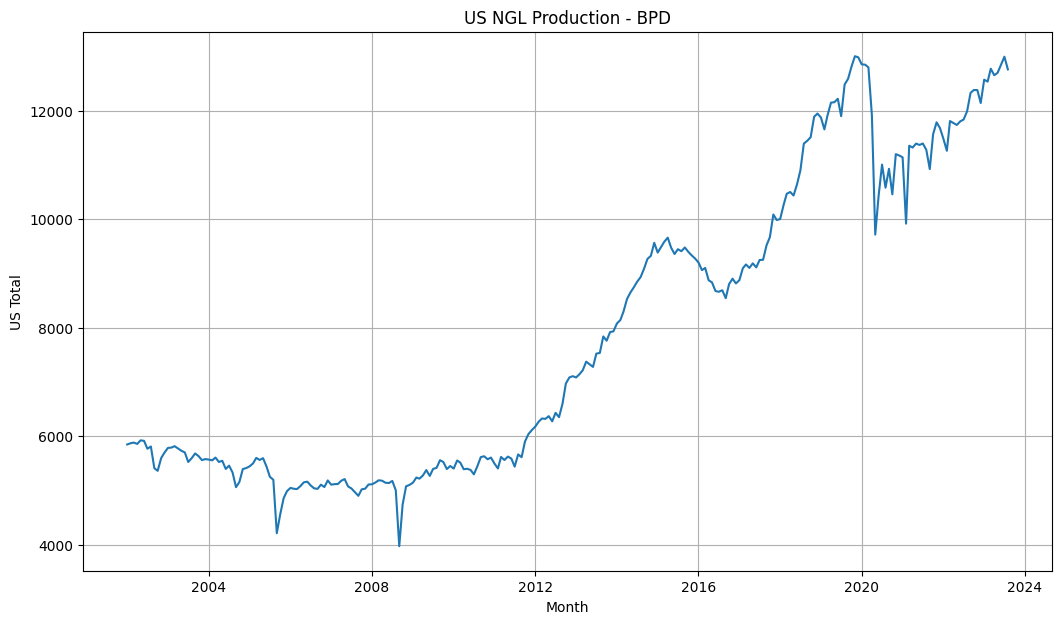

In [31]:
#Visualize the dataframe i.e. US total production in BPD

plt.figure(figsize=(12.5,7))
sns.lineplot(data=df_new[df_new['Product_type']=='Crude oil'], x="Month", y="US Total")
plt.title("US NGL Production - BPD")
plt.grid(True)
plt.show()

Prophet expects that the format of the dataframe to be specific. The model expects a ‘ds’ column  that contains the datetime field and and a ‘y’ column that contains the value we are wanting to model/forecast.

# **Save the final data after Pre-Processing**

In [33]:
df_crude.to_csv('C:/Users/Admin/OneDrive - LTI/Desktop/Foundation _project2/Deployment/US_NGLOil_Final.csv', index=False)

In [35]:
df_crude.columns = ["ds","y"]

#model = Prophet()

# Add a 'cap' column for carrying capacity to the dataset
# capacity_value = 13000  # Example capacity value, maximum data point in the
# df_crude['cap'] = capacity_value

# model = Prophet(
#     growth='linear',               # Model growth trend, either 'linear' or 'logistic'
#     yearly_seasonality='auto',     # Automatically detect yearly seasonality
#     weekly_seasonality='auto',     # Automatically detect weekly seasonality
#     daily_seasonality='auto',      # Automatically detect daily seasonality
#     holidays=None,                 # No holidays dataset included by default
#     seasonality_mode='multiplicative',   # Seasonality mode, either 'additive' or 'multiplicative'
#     seasonality_prior_scale=10.0,  # Strength of the seasonality model
#     holidays_prior_scale=10.0,     # Strength of the holiday components model
#     changepoint_prior_scale=0.1,  # Flexibility of the automatic changepoint selection
#     mcmc_samples=0,                # Number of MCMC samples to draw. Default (0) uses Maximum a Posteriori estimation
#     interval_width=0.80,           # Width of the uncertainty intervals provided for the forecast
#     uncertainty_samples=1000       # Number of simulated draws used to estimate uncertainty intervals
# )

# model.fit(df_crude)

# Grid Search for the Best Model:

In [36]:
# from prophet import Prophet
# from sklearn.metrics import mean_squared_error
# import pandas as pd
# import numpy as np

# # Define a range of parameters to test
# param_grid = {
#     'changepoint_prior_scale': [0.0001,0.001, 0.01, 0.1,0.25,0.45, 0.55, 0.65, 0.75, 0.85,0.95],
#     'seasonality_prior_scale': [1.0, 5.0, 10.0,12,15.0,18, 20.0,24],
#     'holidays_prior_scale': [0.1, 1.0, 3.0, 6.0, 9.0, 10.0, 12.0],
#     'seasonality_mode': ['additive', 'multiplicative']
# }

# # Placeholder for the best parameters and score
# best_params = None
# best_score = float('inf')

# # Loop over all combinations of parameters
# for cps in param_grid['changepoint_prior_scale']:
#     for sps in param_grid['seasonality_prior_scale']:
#         for hps in param_grid['holidays_prior_scale']:
#             for sm in param_grid['seasonality_mode']:
#                 # Create and fit the model
#                 model = Prophet(
#                     growth='linear',
#                     yearly_seasonality='auto',
#                     weekly_seasonality='auto',
#                     daily_seasonality='auto',
#                     holidays=None,
#                     seasonality_mode=sm,
#                     seasonality_prior_scale=sps,
#                     holidays_prior_scale=hps,
#                     changepoint_prior_scale=cps,
#                     mcmc_samples=0,
#                     interval_width=0.80,
#                     uncertainty_samples=500
#                 )
#                 model.fit(df_crude)

#                 # Make predictions (you'll need a future dataframe for this)
#                 future = model.make_future_dataframe(periods= 19, freq='m')
#                 forecast = model.predict(future)

#                 # Evaluate the model (use an appropriate method based on your data)
#                 # Here's an example using RMSE
#                 y_true = df_crude['y']
#                 y_pred = forecast['yhat'][:len(y_true)]
#                 score = np.sqrt(mean_squared_error(y_true, y_pred))

#                 # Update best score and parameters
#                 if score < best_score:
#                     best_score = score
#                     best_params = {
#                         'changepoint_prior_scale': cps,
#                         'seasonality_prior_scale': sps,
#                         'holidays_prior_scale': hps,
#                         'seasonality_mode': sm
#                     }

# # Print the best parameters
# print(f"Best Parameters: {best_params}")


In [37]:
import logging
logging.getLogger().setLevel(logging.ERROR)  # Set to ERROR, WARNING, INFO, or CRITICAL

# **Linear Model**

In [38]:
# from prophet import Prophet
# from sklearn.metrics import mean_squared_error
# import numpy as np
# import pandas as pd

# # Add a 'cap' column for carrying capacity to the dataset

# # capacity_value = 13000  # Maximum capacity value, adjust it as per your data
# # df_crude['cap'] = capacity_value

# # Define a range of parameters to test
# param_grid = {
#     'changepoint_prior_scale': [0.01, 0.1,0.25,0.45, 0.55, 0.65, 0.75, 0.85,0.95],
#     'seasonality_prior_scale': [1.0, 5.0, 10.0,12,15.0,18, 20.0,24],
#     'holidays_prior_scale': [6.0, 9.0, 10.0, 12.0],
#     'seasonality_mode': ['additive', 'multiplicative']
# }

# # Placeholder for the best parameters and score
# best_params = None
# best_score = float('inf')

# # Loop over all combinations of parameters
# for sm in param_grid['seasonality_mode']:
#     for sps in param_grid['seasonality_prior_scale']:
#         for hps in param_grid['holidays_prior_scale']:
#             for cps in param_grid['changepoint_prior_scale']:

#                 # Create and fit the model
#                 model = Prophet(
#                     growth='linear',
#                     yearly_seasonality='auto',
#                     weekly_seasonality='auto',
#                     daily_seasonality='auto',
#                     holidays=None,
#                     seasonality_mode=sm,
#                     seasonality_prior_scale=sps,
#                     holidays_prior_scale=hps,
#                     changepoint_prior_scale=cps,
#                     mcmc_samples=0,
#                     interval_width=0.80,
#                     uncertainty_samples=1000
#                 )

#                 model.fit(df_crude)

#                 # Make predictions (you'll need a future dataframe for this)
#                 future = model.make_future_dataframe(periods=60)  # Adjust as needed
#                 #future['cap'] = capacity_value
#                 forecast = model.predict(future)

#                 # Evaluate the model (use an appropriate method based on your data)
#                 y_true = df_crude['y']
#                 y_pred = forecast['yhat'][:len(y_true)]
#                 score = np.sqrt(mean_squared_error(y_true, y_pred))

#                 # Update the best score and parameters
#                 if score < best_score:

#                     best_score = score
#                     best_params = {
#                         'seasonality_mode': sm,
#                         'seasonality_prior_scale': sps,
#                         'holidays_prior_scale': hps,
#                         'changepoint_prior_scale': cps
#                     }

# # Print the best parameters
# print(f"Best Parameters: {best_params}")


# **Exponential Model**

In [39]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

import logging
logging.getLogger().setLevel(logging.ERROR)  # Set to ERROR, WARNING, INFO, or CRITICAL

# Add a 'cap' column for carrying capacity to the dataset

capacity_value = 13000  # Maximum capacity value, adjust it as per your data
#df_crude['cap'] = capacity_value

# Define a range of parameters to test
param_grid = {
    'changepoint_prior_scale': [0.2,0.35,0.45, 0.55, 0.65, 0.75, 0.85,0.95],
    'seasonality_prior_scale': [1.0, 5.0, 10.0,12,15.0,18, 20.0,24],
    'holidays_prior_scale': [6.0, 9.0, 12.0],
    'seasonality_mode': ['multiplicative']
}

# # Define a range of parameters to test
# param_grid = {
#     'changepoint_prior_scale': [0.0001,0.001, 0.01, 0.1,0.25,0.45, 0.55, 0.65, 0.75, 0.85,0.95],
#     'seasonality_prior_scale': [1.0, 5.0, 10.0,12,15.0,18, 20.0,24],
#     'holidays_prior_scale': [0.1, 1.0, 3.0, 6.0, 9.0, 10.0, 12.0],
#     'seasonality_mode': ['additive', 'multiplicative']
# }

# Placeholder for the best parameters and score
best_params = None
best_score = float('inf')

# Loop over all combinations of parameters
for sm in param_grid['seasonality_mode']:
    for sps in param_grid['seasonality_prior_scale']:
        for hps in param_grid['holidays_prior_scale']:
            for cps in param_grid['changepoint_prior_scale']:

                # Create and fit the model
                model = Prophet(
                    growth='linear',
                    yearly_seasonality='auto',
                    weekly_seasonality='auto',
                    daily_seasonality='auto',
                    holidays=None,
                    seasonality_mode=sm,
                    seasonality_prior_scale=sps,
                    holidays_prior_scale=hps,
                    changepoint_prior_scale=cps,
                    mcmc_samples=0,
                    interval_width=0.80,
                    uncertainty_samples=1000
                )

                model.fit(df_crude)

                # Make predictions (you'll need a future dataframe for this)
                future = model.make_future_dataframe(periods=60)  # Adjust as needed
                #future['cap'] = capacity_value
                forecast = model.predict(future)
                forecast['yhat'] = np.exp(forecast['yhat'])
                forecast['yhat_lower'] = np.exp(forecast['yhat_lower'])
                forecast['yhat_upper'] = np.exp(forecast['yhat_upper'])

                # Evaluate the model (use an appropriate method based on your data)
                y_true = df_crude['y']
                y_pred = forecast['yhat'][:len(y_true)]
                score = np.sqrt(mean_squared_error(y_true, y_pred))

                # Update the best score and parameters
                if score < best_score:

                    best_score = score
                    best_params = {
                        'seasonality_mode': sm,
                        'seasonality_prior_scale': sps,
                        'holidays_prior_scale': hps,
                        'changepoint_prior_scale': cps
                    }

# Print the best parameters
print(f"Best Parameters: {best_params}")


23:11:44 - cmdstanpy - INFO - Chain [1] start processing
23:11:44 - cmdstanpy - INFO - Chain [1] done processing
23:11:45 - cmdstanpy - INFO - Chain [1] start processing
23:11:45 - cmdstanpy - INFO - Chain [1] done processing
23:11:45 - cmdstanpy - INFO - Chain [1] start processing
23:11:45 - cmdstanpy - INFO - Chain [1] done processing
23:11:45 - cmdstanpy - INFO - Chain [1] start processing
23:11:45 - cmdstanpy - INFO - Chain [1] done processing
23:11:46 - cmdstanpy - INFO - Chain [1] start processing
23:11:46 - cmdstanpy - INFO - Chain [1] done processing
23:11:46 - cmdstanpy - INFO - Chain [1] start processing
23:11:46 - cmdstanpy - INFO - Chain [1] done processing
23:11:47 - cmdstanpy - INFO - Chain [1] start processing
23:11:47 - cmdstanpy - INFO - Chain [1] done processing
23:11:47 - cmdstanpy - INFO - Chain [1] start processing
23:11:48 - cmdstanpy - INFO - Chain [1] done processing
23:11:48 - cmdstanpy - INFO - Chain [1] start processing
23:11:49 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15.0, 'holidays_prior_scale': 6.0, 'changepoint_prior_scale': 0.2}


In [40]:
best_params

{'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 15.0,
 'holidays_prior_scale': 6.0,
 'changepoint_prior_scale': 0.2}

In [41]:
model.params

OrderedDict([('lp__', array([[1409.96]])),
             ('k', array([[-0.0355709]])),
             ('m', array([[0.848946]])),
             ('delta',
              array([[ 3.87205e-02, -2.28007e-03,  3.06177e-04, -2.78654e-04,
                       1.23585e-03, -1.52043e-03, -3.06595e-04, -3.27686e-02,
                       1.44943e-01,  3.04416e-01, -2.38645e-01, -7.65224e-02,
                       1.47902e-01, -5.57431e-02, -8.33279e-02,  1.81668e-01,
                       1.32469e-01, -1.71062e-01, -3.35155e-02, -1.55551e-01,
                       1.29239e-02,  2.72493e-01,  8.14970e-02, -2.67807e-01,
                       4.60578e-03]])),
             ('sigma_obs', array([[0.0026466]])),
             ('beta',
              array([[ 0.00081379, -0.00016782, -0.00484737, -0.00108552, -0.00869379,
                      -0.00181737, -0.00165327,  0.00362247,  0.00253291,  0.00157955,
                       0.00641793,  0.00082864,  0.00324319, -0.00070108, -0.00031957,
         

Now its time to start forecasting. With Prophet, we start by building some future time data with the following command:

In [42]:
future = model.make_future_dataframe(periods= 37, freq='m')

In [43]:
# Change the day of each date to '01'
future['ds'] = future['ds'].apply(lambda x: x.replace(day=1))

In this line of code, we created a pandas dataframe with 60 (periods = 60) future data points with a monthly frequency (freq = ‘m’). In the next line of code, we check the last five dates of the forecasted data.

In [44]:
future.tail()

,ds
292,2026-04-01
293,2026-05-01
294,2026-06-01
295,2026-07-01
296,2026-08-01


Now, we will try to predict the actual values using Prophet library and check the last five elements of the forecast.

In [56]:
forecast = model.predict(future)

forecast['trend'] = np.exp(forecast['trend'])
forecast['trend_lower'] = np.exp(forecast['trend_lower'])
forecast['trend_upper'] = np.exp(forecast['trend_upper'])

forecast['yhat'] = np.exp(forecast['yhat'])
forecast['yhat_lower'] = np.exp(forecast['yhat_lower'])
forecast['yhat_upper'] = np.exp(forecast['yhat_upper'])

forecast['multiplicative_terms'] = np.exp(forecast['multiplicative_terms'])
forecast['multiplicative_terms_lower'] = np.exp(forecast['multiplicative_terms_lower'])
forecast['multiplicative_terms_upper'] = np.exp(forecast['multiplicative_terms_upper'])

forecast['yearly'] = np.exp(forecast['yearly'])
forecast['yearly_lower'] = np.exp(forecast['yearly_lower'])
forecast['yearly_upper'] = np.exp(forecast['yearly_upper'])

forecast['additive_terms'] = np.exp(forecast['additive_terms'])
forecast['additive_terms_lower'] = np.exp(forecast['additive_terms_lower'])
forecast['additive_terms_upper'] = np.exp(forecast['additive_terms_upper'])

forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
292,2026-04-01,7649.910910,6380.583484,9299.682597,6364.394727,9216.516243,1.000303,1.000303,1.000303,1.000303,1.000303,1.000303,1.0,1.0,1.0,7670.653139
293,2026-05-01,7693.070399,6349.225956,9438.910830,6345.461683,9339.300432,1.000463,1.000463,1.000463,1.000463,1.000463,1.000463,1.0,1.0,1.0,7725.013235
294,2026-06-01,7737.924363,6317.946581,9516.087618,6324.537047,9537.902891,1.000121,1.000121,1.000121,1.000121,1.000121,1.000121,1.0,1.0,1.0,7746.315914
295,2026-07-01,7781.580410,6250.891226,9639.916492,6287.097559,9685.234910,0.999737,0.999737,0.999737,0.999737,0.999737,0.999737,1.0,1.0,1.0,7763.259363
296,2026-08-01,7826.950426,6272.818095,9829.635392,6272.231168,9831.603666,0.999754,0.999754,0.999754,0.999754,0.999754,0.999754,1.0,1.0,1.0,7809.681972


If we take a look at the data using .tail(), we notice there are a bunch of columns in the forecast dataframe. The important ones (for now) are ‘ds’ (datetime), ‘yhat’ (forecast), ‘yhat_lower’ and ‘yhat_upper’ (uncertainty levels).

In [46]:
forecast[["ds","yhat","yhat_lower","yhat_upper"]].head()

,ds,yhat,yhat_lower,yhat_upper
0,2002-01-01,1692.836569,1640.932954,1744.181391
1,2002-02-01,1684.729376,1637.754016,1734.624703
2,2002-03-01,1724.523690,1673.915020,1778.779328
3,2002-04-01,1729.484230,1683.188705,1778.222390
4,2002-05-01,1729.492485,1680.733350,1782.314873


In [47]:
forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
292,2026-04-01,7670.653139,6435.074156,9035.362147
293,2026-05-01,7725.013235,6431.526491,9142.953221
294,2026-06-01,7746.315914,6364.351509,9244.203113
295,2026-07-01,7763.259363,6348.537452,9260.532624
296,2026-08-01,7809.681972,6349.596987,9445.777393


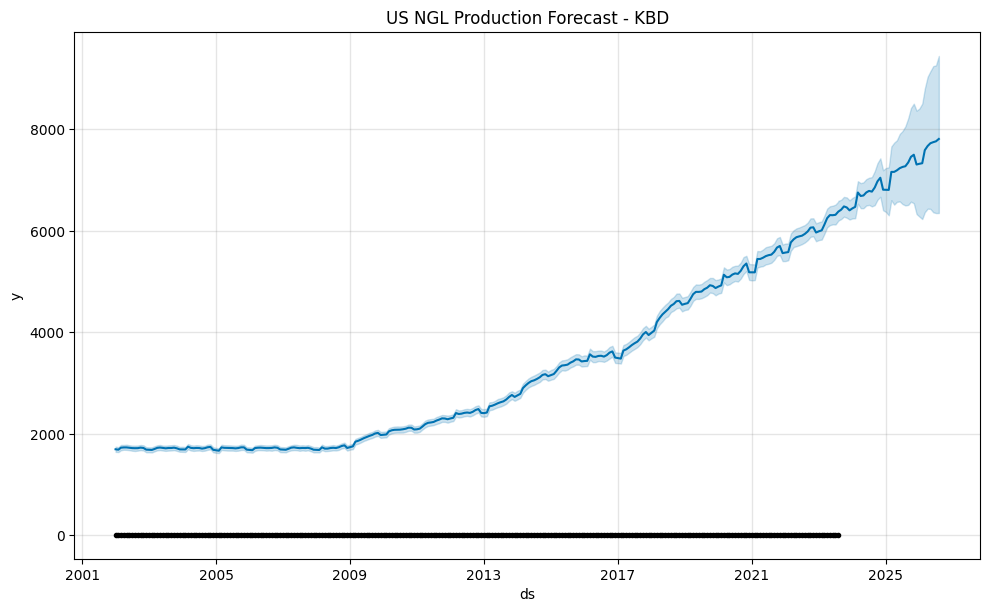

In [48]:
# Plot the graph of this data to get an understanding of how well forecast looks
model.plot(forecast);
plt.title("US NGL Production Forecast - KBD")
plt.show()

In [49]:
df_crude['y'] = np.exp(df_crude['y'])

In [50]:
df_crude.head()

,ds,y
260,2002-01-01,1711.0
261,2002-02-01,1711.0
262,2002-03-01,1711.0
263,2002-04-01,1711.0
264,2002-05-01,1711.0


In [51]:
df_crude_test['y'] = np.exp(df_crude_test['y'])

In [52]:
len(df_crude['y'].values)

260

In [53]:
len(forecast['yhat'].values)

297

# Merge Actual & Forecast dataset based on 'ds'(Date Column)

In [54]:
merged_df = df_crude.merge(forecast, on='ds', how='outer')

In [55]:
merged_df.tail()

,ds,y,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
292,2026-04-01,NaN,7649.910910,6435.074156,9035.362147,6453.835997,8921.914086,1.000303,1.000303,1.000303,1.000303,1.000303,1.000303,1.0,1.0,1.0,7670.653139
293,2026-05-01,NaN,7693.070399,6431.526491,9142.953221,6433.853660,9024.658844,1.000463,1.000463,1.000463,1.000463,1.000463,1.000463,1.0,1.0,1.0,7725.013235
294,2026-06-01,NaN,7737.924363,6364.351509,9244.203113,6407.136994,9166.454405,1.000121,1.000121,1.000121,1.000121,1.000121,1.000121,1.0,1.0,1.0,7746.315914
295,2026-07-01,NaN,7781.580410,6348.537452,9260.532624,6375.119509,9286.770949,0.999737,0.999737,0.999737,0.999737,0.999737,0.999737,1.0,1.0,1.0,7763.259363
296,2026-08-01,NaN,7826.950426,6349.596987,9445.777393,6364.060807,9415.597433,0.999754,0.999754,0.999754,0.999754,0.999754,0.999754,1.0,1.0,1.0,7809.681972


# **Evaluate**

Next, we will check the model robustness using the best metrics for measuring accuracy of this model. Utilizing a combination of R-Squared, Mean Squared Error and Mean Absolute Error will help us to gauge the quality of our model. We will Python's Scikit-Learn library to quickly calculate these metrics.

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# calculate MAE between expected and predicted values for next 60 mont
y_true = merged_df['y'][:260].values
y_pred = merged_df['yhat'][:260].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.2f' % mae)
r = r2_score(y_true, y_pred)
print('R-squared Score: %.4f' % r)

MAE: 52.73
R-squared Score: 0.9957


For the US crude oil time-series data, the Prophet model gives an R-squared value of 0.9956 i.e. 99.57% of variance in our data set is explained by the model. The MAE is calculated to be 52.80 i.e. for each data point, the average magnitude error is roughly 52.80 barrels, considering that our production value is in thousands of barrels.

Finally, we create a plot to compare actual vs. predicted values to give a clear understanding of how our model visually looks against the existing US crude oil production dataset.

In [58]:
df_crude.tail()

,ds,y
515,2023-04-01,6373.0
516,2023-05-01,6376.0
517,2023-06-01,6527.0
518,2023-07-01,6445.0
519,2023-08-01,6375.0


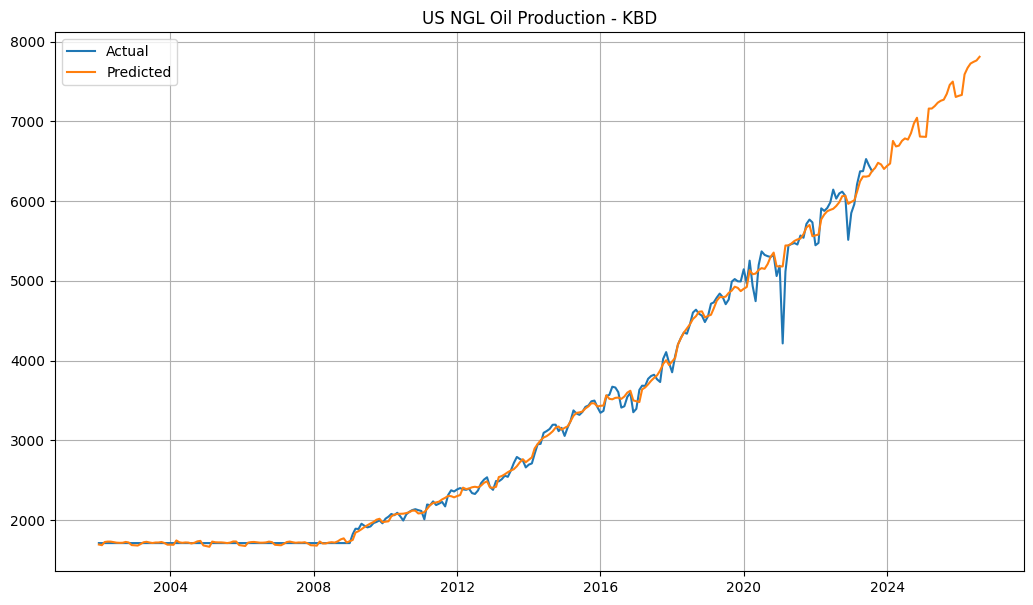

In [66]:
plt.figure(figsize=(12.5,7))
# plot expected vs actual
plt.plot(merged_df['ds'],merged_df['y'], label='Actual')
plt.plot(merged_df['ds'],merged_df['yhat'], label='Predicted')
plt.title("US NGL Oil Production - KBD")
plt.grid(True)
plt.legend()
# Save the plot as a PNG file
plt.savefig("Prophet_NGL_oil_production_plot.png")
plt.show()

# **Evaluation Metrics**

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import numpy as np

y_true = merged_df['y'][:260].values
y_pred = merged_df['yhat'][:260].values

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_true, y_pred))
print("RMSE: ", rmse)

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)
print("MAE: ", mae)

# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE: ", mape, "%")

RMSE:  96.69892024575401
MAE:  52.72683830334189
MAPE:  1.565841704489707 %


In [67]:
# Save the results to a text file
NGLoil_results_file_path = "metrics_results2.txt"
with open(NGLoil_results_file_path, 'w') as file:
    file.write(f"RMSE: {rmse}\n")
    file.write(f"MAE: {mae}\n")
    file.write(f"MAPE: {mape}%\n")

print(f"Metrics results saved to {NGLoil_results_file_path}")

Metrics results saved to metrics_results2.txt


# **Save the Model**

In [62]:
# Save the model to a file
with open('C:/Users/Admin/OneDrive - LTI/Desktop/Foundation _project2/Deployment/US_NGL_prophetModel.pkl', 'wb') as f:
    pickle.dump(model, f)

# **Load the Model**

In [63]:
# Load the model from the file
with open('C:/Users/Admin/OneDrive - LTI/Desktop/Foundation _project2/Deployment/US_NGL_prophetModel.pkl', 'rb') as f:
    US_NGL_loaded_model = pickle.load(f)

In [64]:
US_NGL_loaded_model.params

OrderedDict([('lp__', array([[1409.96]])),
             ('k', array([[-0.0355709]])),
             ('m', array([[0.848946]])),
             ('delta',
              array([[ 3.87205e-02, -2.28007e-03,  3.06177e-04, -2.78654e-04,
                       1.23585e-03, -1.52043e-03, -3.06595e-04, -3.27686e-02,
                       1.44943e-01,  3.04416e-01, -2.38645e-01, -7.65224e-02,
                       1.47902e-01, -5.57431e-02, -8.33279e-02,  1.81668e-01,
                       1.32469e-01, -1.71062e-01, -3.35155e-02, -1.55551e-01,
                       1.29239e-02,  2.72493e-01,  8.14970e-02, -2.67807e-01,
                       4.60578e-03]])),
             ('sigma_obs', array([[0.0026466]])),
             ('beta',
              array([[ 0.00081379, -0.00016782, -0.00484737, -0.00108552, -0.00869379,
                      -0.00181737, -0.00165327,  0.00362247,  0.00253291,  0.00157955,
                       0.00641793,  0.00082864,  0.00324319, -0.00070108, -0.00031957,
         